In [67]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

import _utils # amanda's collected utils
from calitp.sql import to_snakecase

import pandas as pd
import geopandas as gpd
from siuba import *

import shared_utils
import datetime as dt

import gcsfs

from calitp.storage import get_fs
fs = get_fs()

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/project_prioritization/"

# Read In and Clean SWITRS Data

In [2]:
# read in collated/cleaned SWITRS data from Safety Office
switrs = (to_snakecase(
    pd.read_excel(f"{_utils.GCS_FILE_PATH}SWITRS_Full_CACV_20220127.xlsx"))
         ) >> filter(_.sc_accident_year >= 2015)


switrs.head(10)

,sc_case_id,sc_accident_year,proc_date,juris,collision_date,collision_time,officer_id,reporting_district,day_of_week,chp_shift,...,occupantprotectionv,pedestrianv,workzonesv,youngdriversv,id__tb,case_id__tb,point_x__tb,point_y__tb,near_dist_mile,near_tribe
54385,6292116,2015,20150424,3300,20150102,1844,3775,6.02E+05,5,5,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54386,6292117,2015,20160108,9390,20150104,1817,20587,NaN,7,2,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54387,6292117,2015,20160108,9390,20150104,1817,20587,NaN,7,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54388,6292118,2015,20150429,9390,20150105,1650,20557,NaN,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54389,6292119,2015,20150424,103,20150113,1843,8,30,2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54390,6292120,2015,20150429,9525,20150115,1350,16679,NaN,4,1,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54391,6292121,2015,20150429,9220,20150118,2030,13676,NaN,7,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54393,6292126,2015,20150513,1900,20150218,1257,436136,1328,3,5,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
54394,6292127,2015,20170421,3019,20150218,1223,2888,SE,3,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54395,6292128,2015,20150519,9770,20150219,1700,17732,NaN,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
switrs.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90744 entries, 54385 to 159095
Data columns (total 168 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    sc_case_id                   90744 non-null  int64  
 1    sc_accident_year             90744 non-null  int64  
 2    proc_date                    90744 non-null  int64  
 3    juris                        90744 non-null  object 
 4    collision_date               90744 non-null  int64  
 5    collision_time               90744 non-null  int64  
 6    officer_id                   90635 non-null  object 
 7    reporting_district           30706 non-null  object 
 8    day_of_week                  90744 non-null  int64  
 9    chp_shift                    90744 non-null  int64  
 10   population                   90744 non-null  int64  
 11   cnty_city_loc                90744 non-null  int64  
 12   special_cond                 90744 non-null  int64  


In [53]:
# keep only small subset of columns
switrs_small = (switrs >> select(_.sc_case_id,_.sc_accident_year,_.collision_date,_.collision_time,_.sc_collision_severity,
                                 _.pcf_viol_category,_.type_of_collision,_.mviw,
                                 _.number_killed,_.number_injured,_.pedestrian_accident,_.bicycle_accident,_.point_x,_.point_y)
               )

In [54]:
# appears to be all tables (crash, pary, victim) merged together; dedup on sc_case_id
# need to test this assumption at some point
switrs_small = switrs_small.drop_duplicates(subset = ['sc_case_id'])

In [55]:
# make geodataframe w/ relevant columns 
switrs_gdf = gpd.GeoDataFrame(
    switrs_small, geometry=gpd.points_from_xy(switrs_small.point_x, switrs_small.point_y))

In [56]:
switrs_gdf.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 79230 entries, 54385 to 159093
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sc_case_id             79230 non-null  int64   
 1   sc_accident_year       79230 non-null  int64   
 2   collision_date         79230 non-null  int64   
 3   collision_time         79230 non-null  int64   
 4   sc_collision_severity  79230 non-null  int64   
 5   pcf_viol_category      79230 non-null  object  
 6   type_of_collision      79230 non-null  object  
 7   mviw                   79230 non-null  object  
 8   number_killed          79230 non-null  int64   
 9   number_injured         79230 non-null  int64   
 10  pedestrian_accident    15414 non-null  object  
 11  bicycle_accident       5870 non-null   object  
 12  point_x                49306 non-null  float64 
 13  point_y                49306 non-null  float64 
 14  geometry               79

In [57]:
switrs_gdf_geo = (switrs_gdf
                  >> filter(-_.geometry.is_empty)
                 )

<AxesSubplot:>

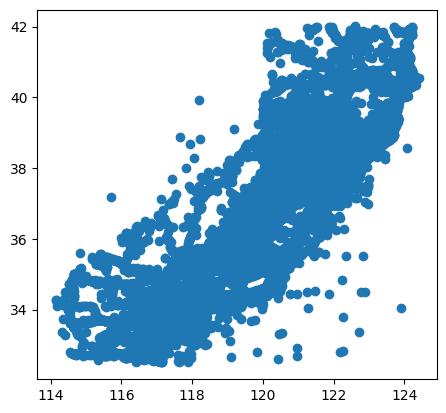

In [58]:
switrs_gdf_geo.plot()

In [59]:
switrs_gdf_geo.head()

,sc_case_id,sc_accident_year,collision_date,collision_time,sc_collision_severity,pcf_viol_category,type_of_collision,mviw,number_killed,number_injured,pedestrian_accident,bicycle_accident,point_x,point_y,geometry
54386,6292117,2015,20150104,1817,1,9,D,C,2,5,NaN,NaN,121.82204,37.61089,POINT (121.82204 37.61089)
54388,6292118,2015,20150105,1650,1,3,A,C,1,2,NaN,NaN,121.92909,37.50050,POINT (121.92909 37.50050)
54390,6292120,2015,20150115,1350,1,3,C,C,1,0,NaN,NaN,117.78874,34.07225,POINT (117.78874 34.07225)
54391,6292121,2015,20150118,2030,1,9,A,C,1,0,NaN,NaN,121.08335,38.92330,POINT (121.08335 38.92330)
54395,6292128,2015,20150219,1700,1,5,A,C,1,0,NaN,NaN,118.92062,34.27878,POINT (118.92062 34.27878)


## Data cleaning

In [60]:
# flip longitude
switrs_gdf_geo = (switrs_gdf_geo
                 >> mutate(point_x_flip = _.point_x*-1)
                 )

In [61]:
switrs_gdf_geo.set_geometry(gpd.points_from_xy(switrs_gdf_geo.point_x_flip, switrs_gdf_geo.point_y), inplace=True)

<AxesSubplot:>

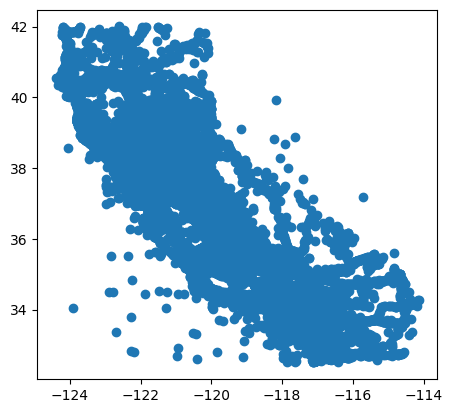

In [62]:
switrs_gdf_geo.plot()

In [63]:
# dates and times
switrs_gdf_geo = (switrs_gdf_geo
                 >> mutate(collision_date_str = _.collision_date.astype(str),
                           collision_time_str = _.collision_time.astype(str)
                          )
                 )

In [64]:
switrs_gdf_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 49306 entries, 54386 to 159093
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sc_case_id             49306 non-null  int64   
 1   sc_accident_year       49306 non-null  int64   
 2   collision_date         49306 non-null  int64   
 3   collision_time         49306 non-null  int64   
 4   sc_collision_severity  49306 non-null  int64   
 5   pcf_viol_category      49306 non-null  object  
 6   type_of_collision      49306 non-null  object  
 7   mviw                   49306 non-null  object  
 8   number_killed          49306 non-null  int64   
 9   number_injured         49306 non-null  int64   
 10  pedestrian_accident    6175 non-null   object  
 11  bicycle_accident       2501 non-null   object  
 12  point_x                49306 non-null  float64 
 13  point_y                49306 non-null  float64 
 14  geometry               49

In [65]:
switrs_gdf_geo['collision_dt'] = pd.to_datetime(switrs_gdf_geo['collision_date_str'], format='%Y%m%d', yearfirst=True)

In [71]:
# Save out
shared_utils.utils.geoparquet_gcs_export(switrs_gdf_geo, GCS_FILE_PATH, "SWITRS_clean")